<a href="https://colab.research.google.com/github/q1ngyM/Github_Colab/blob/main/dict/cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
sys.path.append("../input/d2l-module")
import d2l

In [ ]:
import collections
import math
import os
import csv
import shutil
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from d2l import torch as d2l

In [ ]:
'''
训练数据中：图片切割+随机水平翻转+对RGB三个通道进行标准化
'''
transform_train = torchvision.transforms.Compose([

    torchvision.transforms.Resize(40),
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                             ratio=(1.0, 1.0)),
    torchvision.transforms.RandomHorizontalFlip(),

    torchvision.transforms.ToTensor(),

    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])
'''
测试数据中：只对图片进行通道标准化，消除评估结果中的随机性
'''
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                     [0.2023, 0.1994, 0.2010])])

In [ ]:
batch_size = 128
train_dataset = datasets.CIFAR10(root="../input/cifar10-python", train=True, download=True,transform=transform_train)
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.CIFAR10(root="../input/cifar10-python", train=False, download=False,transform=transform_test)
valid_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


Files already downloaded and verified


In [ ]:
'''
根据上图所示结构对残差块进行定义
'''
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X # 将输入添加到输出
        return Y

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(
                   nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                   )
        self.b2 = nn.Sequential(*resnet_block(64,64,2,first_block=True))
        self.b3 = nn.Sequential(*resnet_block(64,128,2))
        self.b4 = nn.Sequential(*resnet_block(128,256,2))
        self.b5 = nn.Sequential(*resnet_block(256,512,2))
        self.fc = nn.Sequential(
                    nn.AdaptiveAvgPool2d(1),
                    nn.Flatten(),
                    nn.Linear(512, 10)
                    )
    def forward(self,x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        x = self.fc(x)
        return x



In [ ]:
def train_batch(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    # print(f"Type of y: {type(y)}")
    y = y.to(devices[0])

    net.train()
    trainer.zero_grad()  # Clear gradients
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = (pred.argmax(axis=1) == y).float().mean().item()

    return train_loss_sum, train_acc_sum


# lr_period lr_decay 学习率下降方法（每隔多少个epoch减少lr多少 ）
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,lr_decay):
    # 使用随机梯度下降的优化方法
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)

    # 定义学习率调度器，每隔lr-period*epoch将学习率乘以lr_decay
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)

    # 获得批次训练的数量，初始化计时器
    num_batches, timer = len(train_iter), d2l.Timer()

    # 画图
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=legend)

    # 并行化模型，可以在多个设备上运行，虽然不太懂如果我只有一个gpu可用的话写这一句有什么用，但是很多资料上都有这一句，就先抄写下来
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])

    # 损失函数：交叉熵损失
    loss = nn.CrossEntropyLoss()

    # 训练
    for epoch in range(num_epochs):
        net.train()
        # 初始化累加器，记录损失和准确率，比list更方便:[loss,acc,1]
        metric = d2l.Accumulator(3)

        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(net, features, labels, loss, trainer, devices)

            metric.add(l, acc, labels.shape[0])
            # 打印损失
            timer.stop()


            # 每1/5数据更新一次图像
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2], None))


        # 每个epoch结束后用验证集验证准确率
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
        print(metric[1]/metric[2])

        # 打印
        print(f'epoch {epoch + 1}, train loss {metric[0] / metric[2]:.3f}, '
              f'train acc {metric[1] / metric[2]:.3f}, '
              f'valid acc {valid_acc:.3f}' if valid_iter is not None else "")

    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f} '
          f'examples/sec on {str(devices)}')







In [ ]:
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes,3)
    return net

epoch 20, train loss 0.002, train acc 0.007, valid acc 0.847
train loss 0.002, train acc 0.007, valid acc 0.847
1687.1 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


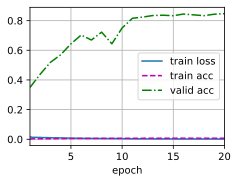

In [ ]:
d2l_net = True
if d2l_net:
    net = get_net()
else:
    net = ResNet()

# Define parameters: devices, epochs, learning rate, weight decay
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 0.1, 5e-4
lr_period, lr_decay = 10, 0.1

# Apply Xavier uniform distribution for model parameter initialization
def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)